# Systems Biology Informed Neural Network

We aim to reimplement the SBINN from the article _Systems Biology: Identifiability analysis and parameter
identification via systems-biology informed neural networks_, M. Daneker et al., 2023, [link](https://arxiv.org/pdf/2202.01723.pdf). This is a `jinns` adaptation of the [code](https://github.com/lu-group/sbinn) acoompanying the article. Results are discussed [here](https://github.com/lu-group/sbinn/issues/4).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
def x_sin2x(x):
    return x + 1 / 0.5 * jnp.sin(0.5 * x) ** 2


def feature_transform(t, params):
    """
    t and params are mandatory parameters for an input_transform function in jinns
    """
    t = 0.01 * t
    return jnp.concatenate(
        [t, jnp.sin(t), jnp.sin(2 * t), jnp.sin(3 * t), jnp.sin(4 * t), jnp.sin(5 * t)],
        axis=0
    )

eqx_list = [
    [eqx.nn.Linear, 6, 128],
    [jax.nn.swish],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.swish],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.swish],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.swish],
    [eqx.nn.Linear, 128, 6]
]



gluc_data = np.hsplit(np.loadtxt("glucose.dat"), [1])
data_t = gluc_data[0]
data_y = gluc_data[1]   

def output_transform(t, y):
    idx = 1799
    t = t.squeeze() * 1
    k = (data_y[idx] - data_y[0]) / (data_t[idx] - data_t[0])
    b = (data_t[idx] * data_y[0] - data_t[0] * data_y[idx]) / (
        data_t[idx] - data_t[0]
    )
    linear = k * t + b
    factor = jnp.tanh(t) * jnp.tanh(idx - t)
    #jax.debug.print("{l}, {y}", l=linear, y=y)
    #jax.debug.print("{x}", x=linear + factor * jnp.array([1, 1, 1e2, 1, 1, 1]) * y)
    return linear + factor * jnp.array([1, 1, 1e2, 1, 1, 1]) * y
    #return jnp.array([1, 1, 1e2, 1, 1, 1]) * y

key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "ODE", input_transform=feature_transform, output_transform=output_transform)

In [6]:
init_nn_params = u.init_params()

Create a DataGenerator object

In [7]:
n = 2048
batch_size = 2048
method = 'uniform'
tmin = 0
tmax = 1800

Tmax = 1
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    subkey,
    n,
    tmin,
    tmax,
    batch_size,                    
    method=method,
#     rar_parameters=rar_parameters,
#     nt_start=n_start
)

## Observations to guide the solution

In [8]:
n = 1800
key, subkey = random.split(key)
idx = jnp.append(
    jax.random.choice(subkey, jnp.arange(1, n - 1), shape=(n // 5,), replace=False),
    jnp.array([0, n - 1])
)

observed_t = data_t[idx].squeeze() / Tmax
print(data_y[0])
observed_y2 = data_y[idx, 2]
observed_y = observed_y2

[   36.    44. 11000.     0.     0.     0.]


## Loss construction and model parameters

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary.

__Note__ that `nn_params` and `eq_params` must always be top level keys but can be nested dictionaries.

__Note__ that the keys of the sub dictionaries `nn_params` and `eq_params` (here `str(i)`) can differ !

In [9]:
# initiate parameters dictionary
init_params = {}

init_params["nn_params"] = init_nn_params

def get_variable(v, var):
        low, up = v * 0.2, v * 1.8
        l = (up - low) / 2
        v1 = l * jnp.tanh(var) + l + low
        return v1
    
E_ = 0.
tp_ = 0.
ti_ = 0.
td_ = 0.
k_ = 0.
Rm_ = 0.
a1_ = 0.
C1_ = 0.
C2_ = 0.
C4_ = 0.
C5_ = 0.
Ub_ = 0.
U0_ = 0.
Um_ = 0.
Rg_ = 0.
alpha_ = 0.
beta_ = 0.

meal_data = jnp.hsplit(np.loadtxt("meal.dat"), [4])
meal_t = meal_data[0].astype(float) / Tmax
meal_q = meal_data[1].astype(float)

init_params["eq_params"] = {
    "Vp":3.,
    "Vi":11.,
    "Vg":10.,
    "E":(jnp.tanh(E_) + 1) * 0.1 + 0.1,
    "tp":(jnp.tanh(tp_) + 1) * 2 + 4,
    "ti":(jnp.tanh(ti_) + 1) * 40 + 60,
    "td":(jnp.tanh(td_) + 1) * 25 / 6 + 25 / 3,
    "k":get_variable(0.0083, k_),
    "Rm":get_variable(209 / 100, Rm_),
    "a1":get_variable(6.6, a1_),
    "C1":get_variable(300 / 100, C1_),
    "C2":get_variable(144 / 100, C2_),
    "C3":100 / 100,
    "C4":get_variable(80 / 100, C4_),
    "C5":get_variable(26 / 100, C5_),
    "Ub":get_variable(72 / 100, Ub_),
    "U0":get_variable(4 / 100, U0_),
    "Um":get_variable(90 / 100, Um_),
    "Rg":get_variable(180 / 100, Rg_),
    "alpha":get_variable(7.5, alpha_),
    "beta":get_variable(1.772, beta_),
    "meal_t":jnp.asarray(meal_t),
    "meal_q":jnp.asarray(meal_q)
}

In [10]:
from jinns.loss._DynamicLossAbstract import ODE

class sbinn(ODE):
    def __init__(self, Tmax=1):
        super().__init__(Tmax)
    
    def evaluate(self, t, u, params):
        out = u(t, params)
        Ip = out[0]
        Ii = out[1]
        G = out[2]
        h1 = out[3]
        h2 = out[4]
        h3 = out[5]
        eq_params = params["eq_params"]
        Vp = eq_params["Vp"]
        Vi = eq_params["Vi"]
        Vg = eq_params["Vg"]
        E = eq_params["E"]
        tp = eq_params["tp"]
        ti = eq_params["ti"]
        td = eq_params["td"]
        k = eq_params["k"]
        Rm = eq_params["Rm"]
        a1 = eq_params["a1"]
        C1 = eq_params["C1"]
        C2 = eq_params["C2"]
        C3 = eq_params["C3"]
        C4 = eq_params["C4"]
        C5 = eq_params["C5"]
        Ub = eq_params["Ub"]
        U0 = eq_params["U0"]
        Um = eq_params["Um"]
        Rg = eq_params["Rg"]
        alpha = eq_params["alpha"]
        beta = eq_params["beta"]
        meal_t = eq_params["meal_t"]
        meal_q = eq_params["meal_q"]

        
        f1 = Rm * jax.nn.sigmoid(G / (Vg * C1) - a1)
        f2 = Ub * (1 - jnp.exp(-G / (Vg * C2)))
        kappa = (1 / Vi + 1 / (E * ti)) / C4
        f3 = (
            U0
            + Um
            / (1 + jnp.power(jnp.maximum(kappa * Ii, (1e-3)), -beta))
        ) / (Vg * C3)
        f4 = Rg * jax.nn.sigmoid(alpha * (1 - h3 / (Vp * C5)))
        dt = Tmax * (t - meal_t)
        IG = jnp.sum(
            meal_q * k * jnp.exp(Tmax * k * (meal_t - t)) * jnp.heaviside(Tmax*(t - meal_t), 0.5)
        )
        IG = jnp.sum(
            0.5 *
            meal_q * k * jnp.exp(-k * dt) * (jnp.sign(dt) + 1)
        )
        tmp = E * (Ip / Vp - Ii / Vi)
        
        #jax.debug.print("{a}, {b}, {c}, {d}, {e}, {f}", a=f1, b=f2, c=f3, d=f4, e=IG, f=tmp)
        
        dIp_dt = jax.grad(lambda t: u(t, params)[0], 0)
        dIi_dt = jax.grad(lambda t: u(t, params)[1], 0)
        dG_dt = jax.grad(lambda t: u(t, params)[2], 0)
        dh1_dt = jax.grad(lambda t: u(t, params)[3], 0)
        dh2_dt = jax.grad(lambda t: u(t, params)[4], 0)
        dh3_dt = jax.grad(lambda t: u(t, params)[5], 0)
        
        return jnp.stack([
            dIp_dt(t) + self.Tmax * (- (f1 - tmp - Ip / tp)),
            dIi_dt(t) + self.Tmax * ( - (tmp - Ii / ti)),
            dG_dt(t) + self.Tmax * ( - (f4 + IG - f2 - f3 * G)),
            dh1_dt(t) + self.Tmax * ( - (Ip - h1) / td),
            dh2_dt(t) + self.Tmax * ( - (h1 - h2) / td),
            dh3_dt(t) + self.Tmax * ( - (h2 - h3) / td)
            ],
            axis=-1
        )

sbinn_dynamic_loss = sbinn(Tmax=Tmax)

In [11]:
loss_weights = {
    "dyn_loss":0, "initial_condition":1., "observations": 1e-2
}

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=sbinn_dynamic_loss,
    obs_batch=[observed_t, observed_y],
    obs_slice=jnp.s_[2]
)


In [12]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    train_data.get_batch()
)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 33649.65234375
Individual losses: {'dyn_loss': '0.00', 'initial_condition': '0.00', 'observations': '33649.65'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [13]:
params = init_params

In [14]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)

In [15]:
n_iter = int(10000)

In [16]:
key, subkey = random.split(key)

In [17]:
params, total_loss_list, loss_by_term_dict, train_data, loss, opt_state, _ = jinns.solve(
    n_iter=n_iter,
    init_params=params,
    data=train_data,
    loss=loss,
    optimizer=tx,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 0: loss value = 33576.91015625
Iteration 1000: loss value = 719.4130859375
Iteration 2000: loss value = 336.00616455078125
Iteration 3000: loss value = 209.27735900878906
Iteration 4000: loss value = 79.65968322753906
Iteration 5000: loss value = 31.38579750061035
Iteration 6000: loss value = 10.407812118530273
Iteration 7000: loss value = 2.9167094230651855
Iteration 8000: loss value = 13.007699966430664
Iteration 9000: loss value = 1.992631435394287
Iteration 10000: loss value = 0.9029627442359924


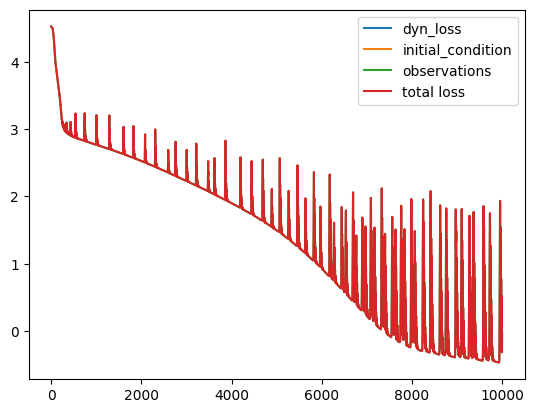

[ 4.5260406   4.525083    4.524011   ... -0.30482948 -0.2886466
 -0.04433016]


In [18]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();
print(jnp.log10(loss_by_term_dict["observations"]))

Following the code provided by the authors, we change the learning weights before continue the optimization further

In [19]:
loss.loss_weights = {
    "dyn_loss":jnp.array([1, 1, 1e-2, 1, 1, 1]), "initial_condition":1, "observations": 1e-2
}

n_iter = 100000
params, total_loss_list, loss_by_term_dict, train_data, loss, opt_state, _ = jinns.solve(
    n_iter=n_iter,
    init_params=params,
    data=train_data,
    loss=loss,
    optimizer=tx,
)

  0%|          | 0/100000 [00:00<?, ?it/s]

Iteration 0: loss value = 5522.1689453125
Iteration 1000: loss value = 38.95571517944336
Iteration 2000: loss value = 33.976470947265625
Iteration 3000: loss value = 31.864545822143555
Iteration 4000: loss value = 16.261390686035156
Iteration 5000: loss value = 15.957389831542969
Iteration 6000: loss value = 14.70418930053711
Iteration 7000: loss value = 14.091182708740234
Iteration 8000: loss value = 8.998287200927734
Iteration 9000: loss value = 6.863107204437256
Iteration 10000: loss value = 7.88573694229126
Iteration 11000: loss value = 6.5311408042907715
Iteration 12000: loss value = 6.851674556732178
Iteration 13000: loss value = 5.278194427490234
Iteration 14000: loss value = 4.845559120178223
Iteration 15000: loss value = 5.104580402374268
Iteration 16000: loss value = 4.932301998138428
Iteration 17000: loss value = 3.882478952407837
Iteration 18000: loss value = 3.8519279956817627
Iteration 19000: loss value = 4.699422836303711
Iteration 20000: loss value = 8.721834182739258
I

## Results

Plot the loss values

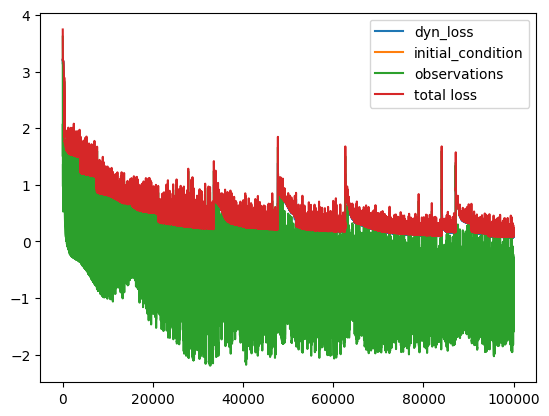

In [20]:
for loss_name, loss_values in loss_by_term_dict.items():
#     if loss_name == "dyn_loss":
        plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN

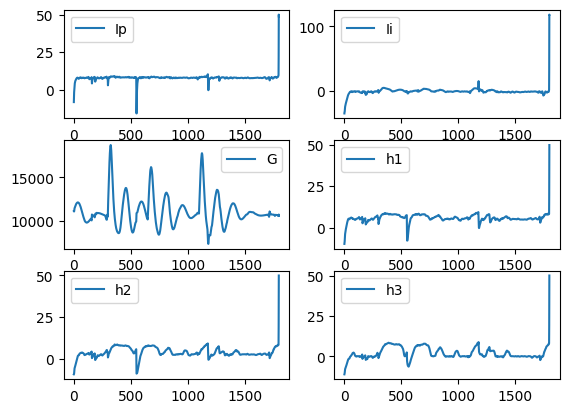

In [21]:
u_est_Ip = vmap(lambda t:u(t, params["nn_params"])[0], (0), 0)
u_est_Ii = vmap(lambda t:u(t, params["nn_params"])[1], (0), 0)
u_est_G = vmap(lambda t:u(t, params["nn_params"])[2], (0), 0)
u_est_h1 = vmap(lambda t:u(t, params["nn_params"])[3], (0), 0)
u_est_h2 = vmap(lambda t:u(t, params["nn_params"])[4], (0), 0)
u_est_h3 = vmap(lambda t:u(t, params["nn_params"])[5], (0), 0)

key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(subkey, n, tmin, tmax, batch_size, method)

fig, axes = plt.subplots(3, 2)
labels = ["Ip", "Ii", "G", "h1", "h2", "h3"]
for i in range(3):
    for j in range(2):
        idx = jnp.ravel_multi_index((i, j), (3, 2))
        u_est_ij = vmap(lambda t:u(t, params["nn_params"])[idx], 0, 0)
        axes[i, j].plot(val_data.times.sort(axis=0) * Tmax, u_est_ij(val_data.times.sort(axis=0)), label=labels[idx])
        axes[i, j].legend()

## Compare with the scipy solver

In [22]:
import numpy as np
from scipy.integrate import odeint


def glucose_insulin_model(
    t,
    meal_t,
    meal_q,
    Vp=3,
    Vi=11,
    Vg=10,
    E=0.2,
    tp=6,
    ti=100,
    td=12,
    k=1 / 120,
    Rm=209,
    a1=6.6,
    C1=300,
    C2=144,
    C3=100,
    C4=80,
    C5=26,
    Ub=72,
    U0=4,
    Um=90,
    Rg=180,
    alpha=7.5,
    beta=1.772,
):
    def func(y, t):
        f1 = Rm / (1 + np.exp(-y[2] / Vg / C1 + a1))
        f2 = Ub * (1 - np.exp(-y[2] / Vg / C2))
        kappa = (1 / Vi + 1 / E / ti) / C4
        f3 = (U0 + Um / (1 + (kappa * y[1]) ** (-beta))) / Vg / C3
        f4 = Rg / (1 + np.exp(alpha * (y[5] / Vp / C5 - 1)))
        IG = np.sum(
            meal_q * k * np.exp(Tmax * k * (meal_t - t)) * np.heaviside(Tmax * (t - meal_t), 0.5)
        )
        tmp = E * (y[0] / Vp - y[1] / Vi)
        return [
            Tmax * (f1 - tmp - y[0] / tp),
            Tmax * (tmp - y[1] / ti),
           Tmax * ( f4 + IG - f2 - f3 * y[2]),
            Tmax * ((y[0] - y[3]) / td),
            Tmax * ((y[3] - y[4]) / td),
            Tmax * ((y[4] - y[5]) / td),
        ]

    Vp0, Vi0, Vg0 = 3, 11, 10
    y0 = [12 * Vp0, 4 * Vi0, 110 * Vg0 ** 2, 0, 0, 0]
    return odeint(func, y0, t)


meal_t = np.array([300, 650, 1100, 2000]) / Tmax
meal_q = np.array([60e3, 40e3, 50e3, 100e3])
t = np.arange(0, 1800, 1)[:, None] / Tmax
y = glucose_insulin_model(np.ravel(t), meal_t, meal_q)

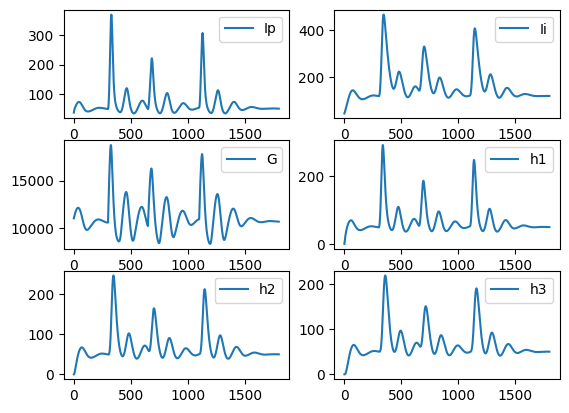

In [23]:
fig, axes = plt.subplots(3, 2)
labels = ["Ip", "Ii", "G", "h1", "h2", "h3"]
for i in range(3):
    for j in range(2):
        idx = jnp.ravel_multi_index((i, j), (3, 2))
        axes[i, j].plot(t * Tmax, y[:, idx], label=labels[idx])
        axes[i, j].legend()

## Alternative approach in `jinns`

Here, we briefly illustrate how to solve the problem using $6$ different PINNs (different sets of parameters but **same architecture** and $6$ Dynamic Losses to estimate the solution.

1) The network architecture changes and we also need to adapt the `output_transform`:

In [24]:
eqx_list = [
    [eqx.nn.Linear, 6, 20],
    [jax.nn.swish],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.swish],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.swish],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.swish],
    [eqx.nn.Linear, 20, 1]
]

def output_transform(t, y, id_component):
    idx = 1799
    t = t.squeeze() * 1
    k = (data_y[idx, id_component] - data_y[0, id_component]) / (data_t[idx] - data_t[0])
    b = (data_t[idx] * data_y[0, id_component] - data_t[0] * data_y[idx, id_component]) / (
        data_t[idx] - data_t[0]
    )
    linear = k.squeeze() * t + b.squeeze()
    factor = jnp.tanh(t) * jnp.tanh(idx - t)

    return linear + factor * jnp.array([1, 1, 1e2, 1, 1, 1])[id_component] * y

2) The network initialisation changes:

In [26]:
from functools import partial
init_nn_params_list = []
nn_list = []
for i in range(6):
    key, subkey = random.split(key)
    u = jinns.utils.create_PINN(
        subkey,
        eqx_list,
        "ODE",
        0,
        input_transform=feature_transform,
        output_transform=partial(output_transform, id_component=i)
    )
    init_nn_params = u.init_params()
    init_nn_params_list.append(init_nn_params)
    nn_list.append(u)

3. The dictionary of parameters changes only for `"nn_params"`:

In [28]:
init_params = {}
nn_keys = ["Ip", "Ii", "G", "h1", "h2", "h3"]
init_params["nn_params"] = {
    nn_keys[i]: init_nn_params_list[i]
    for i in range(6)
}

4. Now we define 6 different Dynamic Losses

In [29]:
from jinns.loss._DynamicLossAbstract import ODE

        
class SBINN_Ip(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        Ip, dIp_dt = jax.value_and_grad(lambda t: u_dict["Ip"](t, nn_params["Ip"], eq_params), 0)(t)
        Ii = u_dict["Ii"](t, nn_params["Ii"], eq_params)
        G = u_dict["G"](t, nn_params["G"], eq_params)
        
        f1 = eq_params["Rm"] * jax.nn.sigmoid(G / (eq_params["Vg"] * eq_params["C1"]) - eq_params["a1"])
        tmp = eq_params["E"] * (Ip / eq_params["Vp"] - Ii / eq_params["Vi"])
        

        return dIp_dt + self.Tmax * (- (f1 - tmp - Ip / eq_params["tp"]))

sbinn_Ip = SBINN_Ip(Tmax=Tmax)

        
class SBINN_Ii(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        Ii, dIi_dt = jax.value_and_grad(lambda t: u_dict["Ii"](t, nn_params["Ii"], eq_params), 0)(t)
        Ip = u_dict["Ip"](t, nn_params["Ip"], eq_params)

        tmp = eq_params["E"] * (Ip / eq_params["Vp"] - Ii / eq_params["Vi"])
        

        return dIi_dt + self.Tmax * ( - (tmp - Ii / eq_params["ti"]))

sbinn_Ii = SBINN_Ii(Tmax=Tmax)

        
class SBINN_G(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        G, dG_dt = jax.value_and_grad(lambda t: u_dict["G"](t, nn_params["G"], eq_params), 0)(t)
        Ii = u_dict["Ii"](t, nn_params["Ii"], eq_params)
        h3 = u_dict["h3"](t, nn_params["h3"], eq_params)

        
        f2 = eq_params["Ub"] * (1 - jnp.exp(-G / (eq_params["Vg"] * eq_params["C2"])))
        kappa = (1 / eq_params["Vi"] + 1 / (eq_params["E"] * eq_params["ti"])) / eq_params["C4"]
        f3 = (
            eq_params["U0"]
            + eq_params["Um"]
            / (1 + jnp.power(jnp.maximum(kappa * Ii, (1e-3)), -eq_params["beta"]))
        ) / (eq_params["Vg"] * eq_params["C3"])
        f4 = eq_params["Rg"] * jax.nn.sigmoid(eq_params["alpha"] * (1 - h3 / (eq_params["Vp"] * eq_params["C5"])))
        dt = Tmax * (t - eq_params["meal_t"])
        IG = jnp.sum(
            0.5
            * eq_params["meal_q"]
            * eq_params["k"]
            * jnp.exp(-eq_params["k"] * dt)
            * (jnp.sign(dt) + 1)
        )

        return dG_dt + self.Tmax * ( - (f4 + IG - f2 - f3 * G))

sbinn_G = SBINN_G(Tmax=Tmax)

        
class SBINN_h1(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        h1, dh1_dt = jax.value_and_grad(lambda t: u_dict["h1"](t, nn_params["h1"], eq_params), 0)(t)
        Ip = u_dict["Ip"](t, nn_params["Ip"], eq_params)


        return dh1_dt + self.Tmax * ( - (Ip - h1) / eq_params["td"])

sbinn_h1 = SBINN_h1(Tmax=Tmax)

class SBINN_h2(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        h2, dh2_dt = jax.value_and_grad(lambda t: u_dict["h2"](t, nn_params["h2"], eq_params), 0)(t)
        h1 = u_dict["h1"](t, nn_params["h1"], eq_params)

        return dh2_dt + self.Tmax * ( - (h1 - h2) / eq_params["td"])

sbinn_h2 = SBINN_h2(Tmax=Tmax)

class SBINN_h3(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        h3, dh3_dt = jax.value_and_grad(lambda t: u_dict["h3"](t, nn_params["h3"], eq_params), 0)(t)
        h2 = u_dict["h2"](t, nn_params["h2"], eq_params)

        return dh3_dt + self.Tmax * ( - (h2 - h3) / eq_params["td"])

sbinn_h3 = SBINN_h3(Tmax=Tmax)

5. Create the system of equations with `SystemLossODE`

In [30]:
loss_weights = {
    "dyn_loss":0.,
    "initial_condition":0.,
    "observations":{"Ip":0., "Ii":0., "G":1e-2, "h1":0., "h2":0., "h3":0.},
}

loss = jinns.loss.SystemLossODE(
    u_dict={"Ii":nn_list[0], "Ip":nn_list[1], "G":nn_list[2], "h1":nn_list[3], "h2":nn_list[4], "h3":nn_list[5]},
    loss_weights=loss_weights,
    dynamic_loss_dict={"Ip":sbinn_Ip, "Ii":sbinn_Ii, "G":sbinn_G, "h1":sbinn_h1, "h2":sbinn_h2, "h3":sbinn_h3},
    initial_condition_dict=None,
    obs_batch_dict={"Ip":None, "Ii":None, "G":[observed_t, observed_y2], "h1":None, "h2":None, "h3":None}
)